# Node2vec Implementation

This algorithm contains two steps:
1. Generate sequences from graph by using random walk
2. Use word2vec model to train embedding matrix from sequences

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import *
import tensorflow as tf
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [2]:
# prepare the graph
row  = np.array([0, 3, 1, 0])
col  = np.array([0, 3, 1, 2])
data = np.array([4, 5, 7, 9])
A = coo_matrix((data, (row, col)), shape=(4, 4)).tocsr() # store it as row matrix for better performance

## Random Walk by using search bias alpha
Let $t$ be the previous node, $v$ be the current node, so the $\pi_{vx}$ for each $x$ node in the graph is defined as below:
$$\pi_{vx} = \alpha_{pq}(t,x)w_{vx}$$
$$\alpha_{pq}(t,x) = \left\{\begin{array}[ll]\\
                \frac{1}{p} & \mbox{if}~d_{tx} = 0\\
                1 & \mbox{if}~d_{tx} = 1\\
                \frac{1}{q} & \mbox{if}~d_{tx} = 2
           \end{array}\right.$$

In [3]:
# current = v
# previous = t
# (t, v) -> next? 
# v connect to (x1, x2, ...)

In [4]:
def alpha(t, x, p, q, data_graph):
    """
    param:
    
    Input:
        @t: int, node index
        @x: int, node index
        @p: float, return factor
        @q: float, go futher factor
        @data_graph: matrix representation for graph
        
    Output:
        @rtype: float
    """
    if t == x:
        return 1.0/p
    elif data_graph[t, x] != 0:
        return 1
    else:
        return 1.0/q

def random_walk(start, p, q, sequence_length, data_graph):
    sequence = []
    for step in range(sequence_length):
        if step == 0:
            sequence.append(start)
        elif step == 1:
            current = data_graph[sequence[step-1],:].toarray().flatten()
            if sum(current) != 0:
                sequence.append(np.random.choice(range(data_graph.shape[1]), p=current/np.linalg.norm(current, ord=1)))
            else:
                sequence.append(sequence[step-1])
        else:
            current = data_graph[sequence[step-1],:].toarray().flatten()
            if sum(current) != 0:
                past = sequence[step-2]
                pi_list = []
                for i in range(data_graph.shape[1]):
                    if current[i] != 0:
                        pi_list.append(alpha(past, i, p, q, data_graph)*current[i])
                    else:
                        pi_list.append(0)
                sequence.append(np.random.choice(range(data_graph.shape[1]), p=pi_list/np.linalg.norm(pi_list, ord=1)))
            else:
                sequence.append(sequence[step-1])
    return sequence

## Define word2vec model

In [5]:
# define neural net as word2vec
class Node2Vec(object):
    """docstring for Node2Vec"""
    def __init__(self, num_nodes, emb_size, lr, batch_size, context_size,num_sampled):
        self.num_nodes = num_nodes
        self.embedding_size = emb_size
        self.lr = lr
        self.batch_size = batch_size
        self.context_size = context_size
        self.num_sampled = num_sampled

    def build(self):
        # Parameters to learn
        global_step = tf.Variable(0, name='global_step', trainable=False)
        
        self.node_embeddings = tf.Variable(tf.random_uniform([self.num_nodes, self.embedding_size], -1.0, 1.0))
        softmax_weights = tf.Variable(tf.truncated_normal([self.num_nodes, self.embedding_size],stddev=1.0 / np.sqrt(self.embedding_size)))
        softmax_biases = tf.Variable(tf.zeros([self.num_nodes]))

        # Input data and re-orgenize size.
        with tf.name_scope("context_node") as scope:
            #context nodes to each input node in the batch (e.g [[1,2],[4,6],[5,7]] where batch_size = 3,context_size=3)
            self.train_context_node= tf.placeholder(tf.int32, shape=[self.batch_size,self.context_size],name="context_node")
            #orgenize prediction labels (skip-gram model predicts context nodes (i.e labels) given a input node)
            #i.e make [[1,2,4,6,5,7]] given context above. The redundant dimention is just for restriction on tensorflow API.
            train_context_node_flat=tf.cast(tf.reshape(self.train_context_node,[-1,1]), tf.float32)
#             print train_context_node_flat
        with tf.name_scope("input_node") as scope:
            #batch input node to the network(e.g [2,1,3] where batch_size = 3)
            self.train_input_node= tf.placeholder(tf.int32, shape=[self.batch_size],name="input_node")
            #orgenize input as flat. i.e we want to make [2,2,2,1,1,1,3,3,3] given the  input nodes above
            input_ones=tf.ones_like(self.train_context_node)
#             input_ones=tf.ones_like(tf.constant(np.zeros(self.context_size)), dtype=tf.int32)
#             train_input_node_flat=tf.reshape(tf.matmul(tf.reshape(self.train_input_node,[-1,1]), tf.reshape(input_ones, [1,-1])),[-1])
            train_input_node_flat=tf.reshape(tf.multiply(input_ones,tf.reshape(self.train_input_node,[-1,1])),[-1])

        # Model.
        with tf.name_scope("loss") as scope:
            # Look up embeddings for words.
            node_embed = tf.nn.embedding_lookup(self.node_embeddings, train_input_node_flat)
#             print node_embed
            # Compute the softmax loss, using a sample of the negative labels each time.
            self.loss_node2vec = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights,softmax_biases,train_context_node_flat, node_embed, self.num_sampled, self.num_nodes))
#             loss_node2vec_summary = tf.scalar_summary("loss_node2vec", self.loss_node2vec)
            
        self.update_loss = tf.train.AdamOptimizer().minimize(self.loss_node2vec,global_step=global_step)
            
            
#         self.train_context_node = tf.placeholder(tf.int32, shape=[self.batch_size, self.context_size]) # (batch_size, context_size)
#         self.train_input_node = tf.placeholder(tf.int32, shape=[self.batch_size, 1])
#         labels = tf.one_hot(self.train_input_node, self.num_nodes) # (batch_size, numb_nodes)
#         self.node_embeddings = tf.Variable(tf.random_uniform([self.num_nodes, self.embedding_size], -1.0, 1.0)) 
#         graph_emb = tf.nn.embedding_lookup(self.node_embeddings, self.train_context_node)# (batch_size, context_size, emb_size)
#         graph_emb = tf.reduce_sum(graph_emb, 1) # (batch_size, emb_size)
#         graph_emb = tf.nn.tanh(graph_emb)
#         W = tf.Variable(tf.truncated_normal([self.embedding_size, self.num_nodes],stddev=1.0 / np.sqrt(self.embedding_size)))
#         b = tf.Variable(tf.zeros([self.num_nodes]))
#         output = tf.nn.xw_plus_b(graph_emb, W, b) # (batch_size, numb_nodes)
#         self.loss_node2vec = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=labels))
#         # loss_node2vec_summary = tf.scalar_summary("loss_node2vec", loss)
#         self.update_loss = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss_node2vec)

## Training process

In [6]:
# read edge data from txt file and store it as csr_matrix
with open("../Data/graph.txt") as f:
    edges = f.readlines()
rows = []
cols = []
data = []
biggest_node_index = 0
for edge in edges:
    row, col = edge.strip().split()
    rows.append(int(row)-1)
#     rows.append(int(col)-1)
    cols.append(int(col)-1)
#     cols.append(int(row)-1)
    data.append(1)
    biggest_node_index = max([max([int(row), int(col)]), biggest_node_index])
data_graph = coo_matrix((data, (rows, cols)), shape=(biggest_node_index, biggest_node_index)).tocsr()

In [7]:
# set some hyperparameter
p=2
q=0.5
num_text = 1000
sequence_length = 32
num_nodes = data_graph.shape[0]
emb_size = 50
lr = 0.1
batch_size = None
context_size = 16
num_epoch = 50
num_sampled = data_graph.shape[0]

### 1. Sample the walk sequence from random walk

In [8]:
# Sampling
corpus = []
for i in tqdm(range(num_text)):
    start = np.random.choice(range(num_nodes))
    corpus.append(random_walk(start, p, q, sequence_length, data_graph))

100%|██████████| 1000/1000 [00:05<00:00, 179.38it/s]


### 2. Build the neural net and train it

In [9]:
# training the neural net
net = Node2Vec(num_nodes, emb_size, lr, batch_size, context_size, num_sampled)
net.build()

In [13]:
init = tf.global_variables_initializer()
# merged = tf.merge_all_summaries()
with tf.Session() as sess:
    log_dir = "./log1"
#     writer = tf.train.SummaryWriter(log_dir, sess.graph)
    sess.run(init)
    t = 0
    emb = None
    for epoch in range(num_epoch):
        for i in range(num_text):
            current_seq = corpus[i]
            labels = np.array([current_seq[j] for j in range(sequence_length - context_size)])
            inputs = np.array([current_seq[j+1:j+1+context_size] for j in range(sequence_length - context_size)])
            feed_dict = {net.train_context_node: inputs, net.train_input_node: labels}
            _, loss = sess.run([net.update_loss, net.loss_node2vec], feed_dict=feed_dict)
        #         writer.add_summary(summary,i)
            t += 1
            if t % 1000 == 0:
                print(loss)
#                 if emb == None:
#                     emb = sess.run(net.node_embeddings)
#                 else:
#                     emb2 = sess.run(net.node_embeddings)
#                     print(np.sum(np.abs(emb - emb2)))
#                     emb = emb2
    # Get the final result
    Final_emb = sess.run(net.node_embeddings)

3.33785e-06
0.000779206
0.00024721
9.39325e-05
0.00772536
0.0616434
0.0392485
0.0
1.1444e-05
4.76836e-06
0.0348534
0.00020192
0.0516816
3.6239e-05
6.38941e-05
0.0
0.0
0.372423
1.12056e-05
0.110786
3.45706e-06
0.00761795
0.0
5.2452e-06
0.0
0.0
0.000725483
6.79491e-06
0.0
0.0
0.0
9.53674e-07
0.0208346
0.0135566
0.0019229
0.0
0.0
0.0
1.3113e-06
5.96045e-06
0.000499243
0.0159609
0.00283305
0.0147491
1.19209e-07
0.0
0.550587
0.0
0.0
0.000887596


### 3. Visualization

In [14]:
# Use t-sne to see the node
low_manifest = TSNE().fit_transform(Final_emb)

In [15]:
low_manifest.shape

(12, 2)

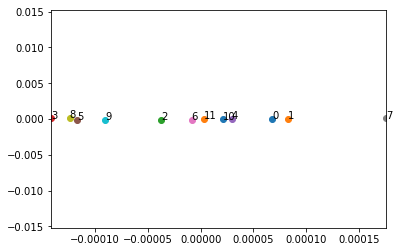

In [16]:
for i in range(len(low_manifest)):
    plt.scatter(low_manifest[i][0], low_manifest[i][1])
    plt.text(low_manifest[i][0], low_manifest[i][1], str(i))
plt.xlim([min(low_manifest[:,0]), max(low_manifest[:,0])])
# plt.ylim([min(low_manifest[:,1]), min(low_manifest[:,1])])
plt.show()

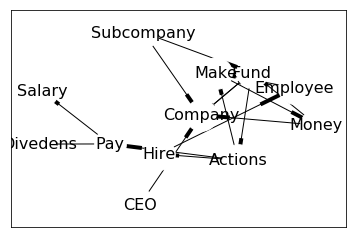

In [17]:
# Visualize the Graph
id_to_name = ['Company', 'Fund', 'Subcompany', 'CEO', 'Actions', 'Make', 'Pay', 'Hire', 'Divedens', 'Salary', 'Employee', 'Money']
name_to_id = {}
for idx, name in enumerate(id_to_name):
    name_to_id[name] = idx
labels = {}
for idx, name in enumerate(id_to_name):
    labels[idx] = name
G = nx.DiGraph(data_graph.toarray())
pos = nx.spring_layout(G)
new_pos = {}
nx.draw_networkx_nodes(G, pos, node_color="w", node_size=1000)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos ,labels=labels, font_size=16, font_color="black")
plt.xticks([])
plt.yticks([])
plt.show()

In [18]:
def is_to(A, B, C, Final_emb, name_to_id, id_to_name):
    # A is to B as C is to ?
    maxi = (cosine_similarity(Final_emb[0].reshape(1, -1), Final_emb[name_to_id[C]].reshape(1, -1)) - cosine_similarity(Final_emb[0].reshape(1, -1), Final_emb[name_to_id[A]].reshape(1, -1)) + cosine_similarity(Final_emb[0].reshape(1, -1), Final_emb[name_to_id[B]].reshape(1, -1)))[0][0]
    max_id = 0
    for i in range(len(Final_emb)):
        current = (cosine_similarity(Final_emb[i].reshape(1, -1), Final_emb[name_to_id[C]].reshape(1, -1)) - cosine_similarity(Final_emb[i].reshape(1, -1), Final_emb[name_to_id[A]].reshape(1, -1)) + cosine_similarity(Final_emb[i].reshape(1, -1).reshape(1, -1), Final_emb[name_to_id[B]].reshape(1, -1)))[0][0]
        if current > maxi:
            max_id = i
            maxi = current
    return id_to_name[max_id]
# cosine_similarity(Final_emb[name_to_id['Company']], Final_emb[name_to_id['Actions']])[0]

In [29]:
# Let's try it!
is_to('Subcompany', 'Actions', 'Money', Final_emb, name_to_id, id_to_name)

'Actions'

In [30]:
from sklearn.preprocessing import normalize

def top_k(C,c_id,cid2cname,topk=5):
    C_norm = normalize(C)
    c_vec=C_norm[c_id]
    sim = np.dot(C_norm,c_vec)
    nearest = (-sim).argsort()[1:topk+1]
    results=[(cid2cname[nearest[k]],sim[nearest[k]]) for k in range(topk)]
    return results

def top_k_vec(C,vec,cid2cname,topk=5):
    C_norm=normalize(C)
    vec_norm=vec/np.linalg.norm(vec)
    sim = np.dot(C_norm,vec_norm)
    nearest = (-sim).argsort()[0:topk]
    results=[(cid2cname[nearest[k]],sim[nearest[k]]) for k in range(topk)]
    return results

def print_top(results):
    for pair in results:
        print(pair[0],pair[1])

In [31]:
print_top(top_k(Final_emb,name_to_id['CEO'],id_to_name))

Company 0.355992
Pay 0.350029
Fund 0.270659
Divedens 0.250789
Actions 0.212085


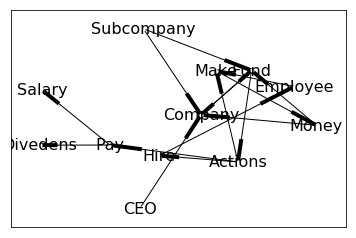

In [37]:
nx.draw_networkx_nodes(G, pos, node_color="w", node_size=10)
nx.draw_networkx_edges(G, pos, width=1, arrows=True)
nx.draw_networkx_labels(G, pos ,labels=labels, font_size=16, font_color="black")
plt.xticks([])
plt.yticks([])
plt.show()

In [35]:
G.edge

{0: {1: {'weight': 1}},
 1: {0: {'weight': 1}, 4: {'weight': 1}},
 2: {0: {'weight': 1}, 1: {'weight': 1}},
 3: {0: {'weight': 1}},
 4: {5: {'weight': 1}, 6: {'weight': 1}, 7: {'weight': 1}},
 5: {11: {'weight': 1}},
 6: {8: {'weight': 1}, 9: {'weight': 1}},
 7: {10: {'weight': 1}},
 8: {},
 9: {},
 10: {5: {'weight': 1}},
 11: {0: {'weight': 1}, 1: {'weight': 1}}}